In [5]:
pip install spotipy


Note: you may need to restart the kernel to use updated packages.


In [2]:
auth_manager = SpotifyOAuth(
    client_id="c7aa41d0b7824f19a437618ffb0e35ee",
    client_secret="8523dbcbd0b2404dbdcf6544678c1aeb",
    redirect_uri="http://127.0.0.1:1234/callback",
    scope="user-library-read"
)

print(auth_manager.get_authorize_url())


https://accounts.spotify.com/authorize?client_id=c7aa41d0b7824f19a437618ffb0e35ee&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A1234%2Fcallback&scope=user-library-read


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="c7aa41d0b7824f19a437618ffb0e35ee",
    client_secret="8523dbcbd0b2404dbdcf6544678c1aeb",
    redirect_uri="http://127.0.0.1:1234/callback",
    scope="user-library-read"
))
print(auth_manager.get_authorize_url())
user_profile = sp.current_user()


print(f"Your Spotify display name is: {user_profile['display_name']}")

https://accounts.spotify.com/authorize?client_id=c7aa41d0b7824f19a437618ffb0e35ee&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A1234%2Fcallback&scope=user-library-read
Your Spotify display name is: Rishitha


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class SPOTIPY:
    def __init__(self, client_id, client_secret, redirect_uri="http://127.0.0.1:1234/callback"):
        # Spotify user-level endpoints
        self.sp = spotipy.Spotify(
            auth_manager=SpotifyOAuth(
                client_id=client_id,
                client_secret=client_secret,
                redirect_uri=redirect_uri,
                scope=(
                    "user-library-read "
                    "user-top-read "
                    "user-follow-read "
                    "user-read-recently-played "
                )
            )
        )
        # Spotify public endpoints
        self.client_sp = spotipy.Spotify(
            client_credentials_manager=SpotifyClientCredentials(
                client_id=client_id,
                client_secret=client_secret
            )
        )

    # ---------------- Spotify Methods ---------------- #
    def get_liked_songs(self, limit=40):
        liked_songs = self.sp.current_user_saved_tracks(limit=limit)
        all_tracks = []
        track_counter = 0
        while liked_songs:
            for item in liked_songs['items']:
                track = item['track']
                artist = track['artists'][0]
                album = track.get('album', {})
                all_tracks.append({
                    "index": track_counter,
                    "artist": artist.get('name', 'Unknown'),
                    "artist_id": artist.get('id', 'Unknown'),
                    "name": track.get('name', 'Unknown'),
                    "id": track.get('id', 'Unknown'),
                    "url": track['external_urls'].get('spotify', ''),
                    "album_name": album.get('name', 'Unknown'),
                    "album_id": album.get('id', 'Unknown'),
                    "release_date": album.get('release_date', '1900-01-01'),
                    "duration_ms": track.get('duration_ms', 0),
                    "explicit": track.get('explicit', False),
                    "popularity": track.get('popularity', 0),
                    "added_at": item.get('added_at', None)
                })
                track_counter += 1
            if liked_songs['next']:
                liked_songs = self.sp.next(liked_songs)
            else:
                break
        return all_tracks


    def get_artist_albums(self, artist_uri, album_type="album"):
        """Fetch all albums of an artist"""
        results = self.client_sp.artist_albums(artist_uri, album_type=album_type)
        albums = results['items']
        while results['next']:
            results = self.client_sp.next(results)
            albums.extend(results['items'])
    
        return [{
            "name": album['name'],
            "id": album['id'],
            "url": album['external_urls']['spotify']
        } for album in albums]

    def search_playlists(self, query, limit=10):
        """Search playlists by keyword"""
        results = self.sp.search(q=query, type='playlist', limit=limit)
        playlists = []
        for playlist in results['playlists']['items']:
            if playlist:
                playlists.append({
                    "name": playlist.get("name"),
                    "id": playlist.get("id"),
                    "url": playlist.get("external_urls", {}).get("spotify")
                })
        return playlists

    def get_my_playlists(self, limit=20):
        """Fetch your playlists"""
        playlists = self.sp.current_user_playlists(limit=limit)
        my_playlists = []
        while playlists:
            for playlist in playlists['items']:
                my_playlists.append({
                    "name": playlist['name'],
                    "id": playlist['id'],
                    "url": playlist['external_urls']['spotify'],
                    "track_count": playlist['tracks']['total']
                })

            if playlists['next']:
                playlists = self.sp.next(playlists)
            else:
                break

        return my_playlists


    def get_artist_top_tracks(self, artist_uri, limit=10, market="IN"):
        """
        Get top tracks of a given artist (works without user login).
        """
        results = self.client_sp.artist_top_tracks(artist_uri, country=market)
        tracks = results.get('tracks', [])[:limit]
        return [{
            "rank": idx+1,
            "name": track['name'],
            "preview": track['preview_url'] if track['preview_url'] else "No preview available",
            "cover_art": track['album']['images'][0]['url'] if track['album']['images'] else None,
            "url": track['external_urls']['spotify']
        } for idx, track in enumerate(tracks)]


    def get_new_releases(self, country="IN", limit=10):
        """
        Fetch new album releases by country.
        Default: India ("IN")
        """
        results = self.client_sp.new_releases(country=country, limit=limit)
        albums = results.get('albums', {}).get('items', [])
        return [{
            "name": album['name'],
            "artist": album['artists'][0]['name'],
            "url": album['external_urls']['spotify'],
            "cover_art": album['images'][0]['url'] if album['images'] else None
        } for album in albums]


    def get_my_following(self, limit=20):
        """
        Get the list of artists the current user is following.
        Requires scope: user-follow-read
        """
        results = self.sp.current_user_followed_artists(limit=limit)
        artists = results.get('artists', {}).get('items', [])
        
        return [{
            "name": artist['name'],
            "id": artist['id'],
            "url": artist['external_urls']['spotify'],
            "genres": artist.get('genres', []),
            "followers": artist['followers']['total']
        } for artist in artists]


    def get_my_top_tracks(self, limit=10, time_range="medium_term"):
        """
        Returns the top tracks for the current user.
        time_range: 'short_term', 'medium_term', 'long_term'
        """
        top_tracks = self.sp.current_user_top_tracks(limit=limit, time_range=time_range)
        items = top_tracks.get('items', [])
    
        return [{
            "rank": idx+1,
            "artist": track['artists'][0]['name'],
            "name": track['name'],
            "id": track['id'],
            "url": track['external_urls']['spotify']
        } for idx, track in enumerate(items)]


    def to_csv(self, df, filename="spotify_data.csv", index=False):
        """ Save a Pandas DataFrame to a CSV file """
        try:
            df.to_csv(filename, index=index, encoding="utf-8")
            print(f" Data saved to {filename}")
        except Exception as e:
            print(f" Error saving to CSV: {e}")  

    # ---------------- Visualizations ---------------- #

    def artist_growth(self, artist_uri):
        """Plot average album popularity trend for an artist"""
        albums = self.get_artist_albums(artist_uri)

        album_data = []
        for album in albums:
            tracks = self.client_sp.album_tracks(album["id"])["items"]
            ids = [t["id"] for t in tracks if t["id"]]
            if not ids:
                continue
            features = self.sp.tracks(ids)["tracks"]
            avg_pop = np.mean([t["popularity"] for t in features if t])
            album_data.append({"album": album["name"], "popularity": avg_pop})

        df_albums = pd.DataFrame(album_data)

        plt.figure(figsize=(10,4))
        plt.plot(df_albums["album"], df_albums["popularity"], marker="o")
        plt.xticks(rotation=45, ha="right")
        plt.title("Artist Growth (Album Popularity)")
        plt.ylabel("Average Popularity")
        plt.xlabel("Album")
        plt.show()

        return df_albums

    def genre_distribution(self, limit=50):
        """Pie chart of genres from followed artists"""
        artists = self.get_my_following(limit=limit)
        genres = [g for a in artists for g in a["genres"]]
        if not genres:
            print("No genre data available.")
            return
    
        counts = pd.Series(genres).value_counts().head(8)
        plt.figure(figsize=(6,6))
        plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
        plt.title("Your Top Genres")
        plt.show()

    def artist_growth_bubble(self, artist_uri):
        """
        Bubble chart of artist's album growth (avg popularity vs year vs track count).
        """
        albums = self.get_artist_albums(artist_uri)
        data = []
    
        for album in albums:
            results = self.client_sp.album_tracks(album["id"])
            track_ids = [t["id"] for t in results["items"] if t.get("id")]
    
            if not track_ids:
                continue
    
            # Fetch full track objects (metadata + popularity)
            tracks = self.client_sp.tracks(track_ids)["tracks"]
    
            pops = [t["popularity"] for t in tracks if t]
            if not pops:
                continue
    
            # Album release year
            album_meta = self.client_sp.album(album["id"])
            year = int(album_meta["release_date"][:4])
    
            data.append({
                "album": album["name"],
                "year": year,
                "avg_popularity": np.mean(pops),
                "track_count": len(pops)
            })
    
        df = pd.DataFrame(data).reset_index(drop=True)
    
        # Bubble chart
        plt.figure(figsize=(15,10))
        plt.scatter(df["year"], df["avg_popularity"],
                    s=df["track_count"] * 20, alpha=0.6, c=df["avg_popularity"],
                    cmap="viridis")
        for i, row in df.iterrows():
            plt.text(row["year"], row["avg_popularity"], row["album"], fontsize=8, ha="center")
    
        plt.xlabel("Year")
        plt.ylabel("Average Popularity")
        plt.title("Artist Growth Over Albums")
        plt.colorbar(label="Avg Popularity")
        plt.show()
    
        return 

    def top_artists_bar(self, limit=10):
        """ Top artists bar chart """
        artists = self.get_my_following(limit=50)
        df = pd.DataFrame(artists)
        df = df.sort_values("followers", ascending=False).head(limit).reset_index(drop=True)
    
        plt.figure(figsize=(10,5))
        sns.barplot(x="followers", y="name", data=df, palette="magma")
        plt.title("Top Followed Artists")
        plt.xlabel("Followers")
        plt.ylabel("Artist")
        plt.show()
        return


    def release_year_distribution(self, limit=50):
        """ Release year wise distribution for liked songs """
        liked = self.get_liked_songs(limit=limit)
        years = []
        for t in liked:
            album = self.client_sp.album(self.sp.track(t["id"])["album"]["id"])
            years.append(int(album["release_date"][:4]))
    
        plt.figure(figsize=(10,5))
        sns.histplot(years, bins=20, kde=False, color="lightgreen")
        plt.title("Distribution of Liked track Release Years")
        plt.xlabel("Year")
        plt.ylabel("Count")
        plt.show()

    

    # ---------------- PostgreSQL Methods ---------------- #
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    def generate_create_table_statement(self, df, table_name="spotify_liked_songs_data"):
        # creating table 
        columns = df.dtypes
        sql_columns = ",\n    ".join(
            [f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()]
        )
        return f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );
        """

    def save_to_postgres(self, df, conn_params, table_name="spotify_liked_songs_data"):
        """ saving to postgresql """
        create_stmt = self.generate_create_table_statement(df, table_name)
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            cur.execute(create_stmt)
            conn.commit()

            columns = list(df.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(c) for c in columns])})
            VALUES ({placeholders})
            """
            for _, row in df.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

    def read_from_postgresql(self, conn_params, table_name="spotify_liked_songs_data"):
        """ reading from postgresql """
        try:
            conn = psycopg2.connect(**conn_params)
            df = pd.read_sql(f'SELECT * FROM {table_name}', conn)
            conn.close()
            return df
        except Exception as e:
            print(f"Error reading from PostgreSQL: {e}")
            return None

In [5]:
if __name__ == "__main__":
    client_id = "c7aa41d0b7824f19a437618ffb0e35ee"
    client_secret = "8523dbcbd0b2404dbdcf6544678c1aeb"

    # Create object
    music = SPOTIPY(client_id, client_secret)

In [6]:
# Get liked songs
liked = music.get_liked_songs(limit=20)
for track in liked[:20]:  # print only first 20
    print(f"{track['index']}: {track['artist']} - {track['name']} ({track['url']})")

0: Shilpa Rao - Chuttamalle (From "Devara Part 1") (https://open.spotify.com/track/1bxzr3JK05fMTcweGAZUHp)
1: S. P. Balasubrahmanyam - Allantha Doorala (https://open.spotify.com/track/5jDcZCA2NJEvk7Kwa6bcE1)
2: S. P. Balasubrahmanyam - Suvvi Suvvi (https://open.spotify.com/track/2W21xyDCFlrgOzK2Yqv2X5)
3: Ghantasala - Prema Yatralaku (https://open.spotify.com/track/3NVSHFKnsSL0wxrgU9QqKo)
4: Ghantasala - Nannu Dochu Kunduvatey (https://open.spotify.com/track/3AbxgsYRFyr6ycX60IeduW)
5: Karthik - Hoyna (https://open.spotify.com/track/2RB0HGpFZ3ScPEqC7uCqr3)
6: Rajesh - Emainadho Emo (https://open.spotify.com/track/4A6j0Du0IrhL5F8smYVMTq)
7: Mallikarjun - Chitti Nadumune (https://open.spotify.com/track/4NugyVw9Of2Z4uyBXf33tX)
8: Karthik - Naa Pere Kanchanamaala (https://open.spotify.com/track/1e6r9GfyjrTUqmKohbswQn)
9: Chakri - Ninne Ninne (https://open.spotify.com/track/6plyDAqUmEjWVPjM12udlU)
10: Karthik - Kannula Baasalu (https://open.spotify.com/track/7eFFgsETjYqTKKMCk3Z6VW)
11: Amrit

In [8]:
# Get artist albums
birdy_uri = "spotify:artist:2WX2uTcsvV5OnS0inACecP"
albums = music.get_artist_albums(birdy_uri)
print("\nAlbums by Birdy:")
for album in albums:
    print(f"{album['name']} ({album['url']})")


Albums by Birdy:
Portraits (+ Remixes) (https://open.spotify.com/album/2QTZiOy0LlRpC8FGUSXQoO)
Portraits (https://open.spotify.com/album/0ntTitta8btOS93RiM3TrO)
Young Heart (https://open.spotify.com/album/4qsLVZk1UnizpQJBkbFNdx)
Beautiful Lies (Deluxe) (https://open.spotify.com/album/2uNFpEVey5RsxzTdoDmjiz)
Beautiful Lies (https://open.spotify.com/album/1UVggFtdVPqHy5WamYFu6w)
Fire Within (Deluxe) (https://open.spotify.com/album/24f6ycLAjcI8rNYfV6WZvS)
Fire Within (https://open.spotify.com/album/1JCe9MAwb1aE01UoAwCnOM)
Fire Within (https://open.spotify.com/album/0r94AFhRLvpfXvha7vx2dK)
Live in London (https://open.spotify.com/album/55BQeeBdoCapsI5SZFA3IN)
Birdy (Deluxe Version) (https://open.spotify.com/album/3sGzkurA1fvEFqh73sWCVA)
Birdy (https://open.spotify.com/album/1WGjSVIw0TVfbp5KrOFiP0)


In [9]:
# Search playlists
playlists = music.search_playlists("SP Balasubrahmanyam")
print("\nPlaylists:")
for p in playlists:
    print(f"{p['name']} ({p['url']})")


Playlists:
S.P. Balasubramanyam Telugu Hits  (https://open.spotify.com/playlist/33iTf68UhEmcJHpzTsq3fD)
S.P. Balasubramanyam Telugu All Time Hits | Top 500 Hits (https://open.spotify.com/playlist/3WYSAYYnNt79VK4yZh0Uod)
S. P. BALASUBRAHMANYAM (SPB) - Kannada (https://open.spotify.com/playlist/7aoniRe3ltNPfTMTeKWaOc)
SP . BALASUBRAMANIAM SONGS (https://open.spotify.com/playlist/0iPiwXkkIbI9vMZy19zbqD)
SP Balasubramaniam (Tamil)  (https://open.spotify.com/playlist/6wbsYapPN8Q8qKOKJI268C)
SPB Kannada Super Hits (https://open.spotify.com/playlist/1jWMdzmeLF4EqBrvAjgOkA)
Best Of S.P. Balasubrahmanyam (Hindi) (https://open.spotify.com/playlist/6Ngsg7kqeIKZu4YEnWxY8d)


In [10]:
#Fetch my playlists
my_playlists = music.get_my_playlists()
print("\nYour Playlists:")
for p in my_playlists:
    print(f"{p['name']} ({p['url']}) - {p['track_count']} tracks")


Your Playlists:
item songs (https://open.spotify.com/playlist/3ENqbqy0X7aTH5Q9xA1Zaq) - 0 tracks
⭐ (https://open.spotify.com/playlist/6GgRgSnWwx2oMLJ7VnHvud) - 16 tracks
💜 (https://open.spotify.com/playlist/62p7E8G62fs5CVLXDM73yz) - 220 tracks
Melody (https://open.spotify.com/playlist/76ATSGUmMUTRSKRF8LCj6c) - 4 tracks
😎😎 (https://open.spotify.com/playlist/3GrUzY2CLMbXEcRds5qYir) - 35 tracks


In [11]:
# Fetch actor's top tracks
chiranjeevi_uri = "spotify:artist:1ufJdfFZl0Tui0VKz3qpXg"
top_tracks = music.get_artist_top_tracks(chiranjeevi_uri, limit=10)

print(" Chiranjeevi Top Tracks:")
for t in top_tracks:
    print(f"{t['rank']}. {t['name']}")
    print(f"   URL: {t['url']}")
    print(f"   Cover: {t['cover_art']}")

 Chiranjeevi Top Tracks:
1. Akalesthey
   URL: https://open.spotify.com/track/6yVeYqlH4yUGgMFoBa1qlA
   Cover: https://i.scdn.co/image/ab67616d0000b2737baf9cc8ad21a690f037e7c6
2. Radhe Govinda
   URL: https://open.spotify.com/track/119Nfz7pgWGUMomvLcCNJa
   Cover: https://i.scdn.co/image/ab67616d0000b2730510775463ffae4a90b6a058
3. Abbanee
   URL: https://open.spotify.com/track/1fJDaMZnbiXG4e8MsFhSDp
   Cover: https://i.scdn.co/image/ab67616d0000b273189bf533b670eb9ee54ad15f
4. Maha Muddu
   URL: https://open.spotify.com/track/63cdUH7934Y3Glreb3uSzE
   Cover: https://i.scdn.co/image/ab67616d0000b273515c8a1421d1698547e0a8ce
5. Abbo Neeyamma
   URL: https://open.spotify.com/track/4bnUYODlONhyeImYQl2B8L
   Cover: https://i.scdn.co/image/ab67616d0000b2735278ae57a228c55ba3248bf1
6. Aata Kaavala
   URL: https://open.spotify.com/track/6H0lL7IBfG3eHoy80YoIQm
   Cover: https://i.scdn.co/image/ab67616d0000b273daece882b1f3402254ddf605
7. Yamaho Nee
   URL: https://open.spotify.com/track/6HqQXFcUade

In [12]:
# Fetch new releases within a country
new_releases = music.get_new_releases(country="IN", limit=10)
print(" New Releases in India:")
for nr in new_releases:
    print(f"{nr['name']} by {nr['artist']}")
    print(f"URL: {nr['url']}")
    print(f"Cover: {nr['cover_art']}")
    print()

 New Releases in India:
幕が上がる by back number
URL: https://open.spotify.com/album/7EMnnvi7tiuruBRbW9Zr92
Cover: https://i.scdn.co/image/ab67616d00001e022aad6bcba8ee87def999e2e5

illusion by Ryokuoushoku Shakai
URL: https://open.spotify.com/album/7tOkQxseZlORjYoyUkE0MZ
Cover: https://i.scdn.co/image/ab67616d00001e02d6b8ebbddc9b0370281b6465

Stateside by PinkPantheress
URL: https://open.spotify.com/album/5YDrgVxfvOkmp1OYjXB29z
Cover: https://i.scdn.co/image/ab67616d00001e029b58eec8635dc031fd162c90

言伝 ―ことづて― by PornoGraffitti
URL: https://open.spotify.com/album/6xobEgpXTdqi5vU4lqLi4J
Cover: https://i.scdn.co/image/ab67616d00001e020356b24eeaaf072d3e2094f6

バグり (feat. kZm, Awich, PETZ, MonyHorse & JNKMN) by YENTOWN
URL: https://open.spotify.com/album/2fPFTelUOr9Nw72DW55aHU
Cover: https://i.scdn.co/image/ab67616d00001e02ab168dd120e2c692ea45d198

FNF by Tiji Jojo
URL: https://open.spotify.com/album/65zERkLZ5jhy7Emo8oEMWz
Cover: https://i.scdn.co/image/ab67616d00001e02befc8137de3448ed44e9de52


In [13]:
# Following artists
following = music.get_my_following(limit=10)
print("Artists you follow:")
for f in following:
    print(f"{f['name']} ({f['url']}) | Followers: {f['followers']}")

Artists you follow:
blink-182 (https://open.spotify.com/artist/6FBDaR13swtiWwGhX1WQsP) | Followers: 9237457
Abhijeet (https://open.spotify.com/artist/2ZRrPOjBIWoKK5rHedLijj) | Followers: 5850622
Mani Sharma (https://open.spotify.com/artist/3AMxH9QIPZbK8ND8C9j4Ss) | Followers: 4507958
S. P. Balasubrahmanyam (https://open.spotify.com/artist/2ae6PxICSOZHvjqiCcgon8) | Followers: 21504083
R. P. Patnaik (https://open.spotify.com/artist/00hL0oJD4pWef0kPYIaSTy) | Followers: 1429238
Ranjith Govind (https://open.spotify.com/artist/7zFlr6Y537SdALqy0Xfvth) | Followers: 1110368
Chakri (https://open.spotify.com/artist/7puWXcCM8Li3HnKrxc1bEH) | Followers: 1919171
Neha Kakkar (https://open.spotify.com/artist/5f4QpKfy7ptCHwTqspnSJI) | Followers: 48785125
Arijit Singh (https://open.spotify.com/artist/4YRxDV8wJFPHPTeXepOstw) | Followers: 160701633
Devi Sri Prasad (https://open.spotify.com/artist/5sSzCxHtgL82pYDvx2QyEU) | Followers: 12047895


In [14]:
most_played = music.get_my_top_tracks(limit=10, time_range="long_term")
for t in most_played:
    print(f"{t['rank']}. {t['artist']} - {t['name']} ({t['url']})")

1. Karthik - Nijanga Nenena (https://open.spotify.com/track/5haAVKCKAfb7IYLplcao0h)
2. S. P. Balasubrahmanyam - Allantha Doorala (https://open.spotify.com/track/5jDcZCA2NJEvk7Kwa6bcE1)
3. Yuvan Shankar Raja - Nee Yadalo Naaku (https://open.spotify.com/track/4wUOdPcYoqYZGM2wSdoLQu)
4. Amritavarshini KC - Chinuku Taake.. (https://open.spotify.com/track/4ewe55AoVtNZQZMihVmp9u)
5. Adithya Reddy - Revanth Reddy Song (https://open.spotify.com/track/2Le3Jnt7cQ827LTtPYVjF2)
6. Karthik - Hoyna (https://open.spotify.com/track/2RB0HGpFZ3ScPEqC7uCqr3)
7. KK - My Heart is Beating (https://open.spotify.com/track/3ppaMjhBDxRi2kTpawOSJn)
8. K. J. Yesudas - Kathalo Rajakumari (https://open.spotify.com/track/44T4sbUg7TaU5xe33gmOlx)
9. Udit Narayan - Cheppave Chirugali (https://open.spotify.com/track/0k0isUYnsgYBKjJQykg3uN)
10. Malavika - Untale Untale Nee Vente Untale (https://open.spotify.com/track/1oORqh1V6hWPpN6UdaaBdq)


In [15]:
# Get liked songs and save to CSV
liked = music.get_liked_songs(limit=50)
df = pd.DataFrame(liked)
music.to_csv(df, "liked_songs.csv")

 Data saved to liked_songs.csv


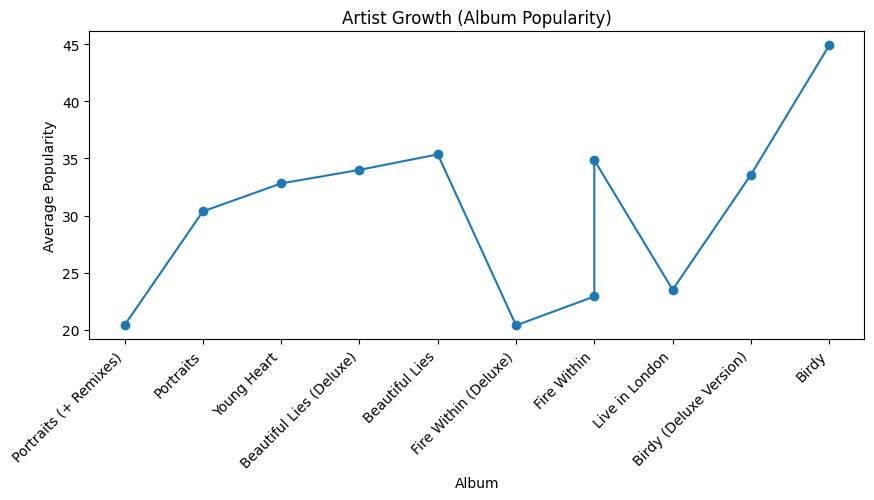

                      album  popularity
0     Portraits (+ Remixes)   20.400000
1                 Portraits   30.363636
2               Young Heart   32.812500
3   Beautiful Lies (Deluxe)   34.000000
4            Beautiful Lies   35.357143
5      Fire Within (Deluxe)   20.375000
6               Fire Within   22.909091
7               Fire Within   34.846154
8            Live in London   23.500000
9    Birdy (Deluxe Version)   33.571429
10                    Birdy   44.909091


In [17]:
# Artists growth
growth = music.artist_growth(birdy_uri)
print(growth)

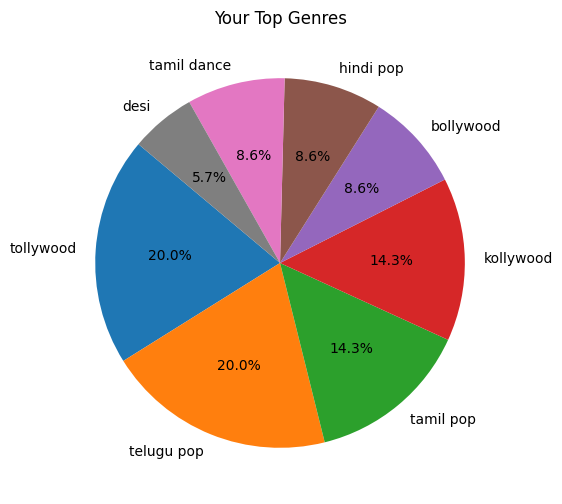

In [18]:
# top genres
music.genre_distribution(limit=50)

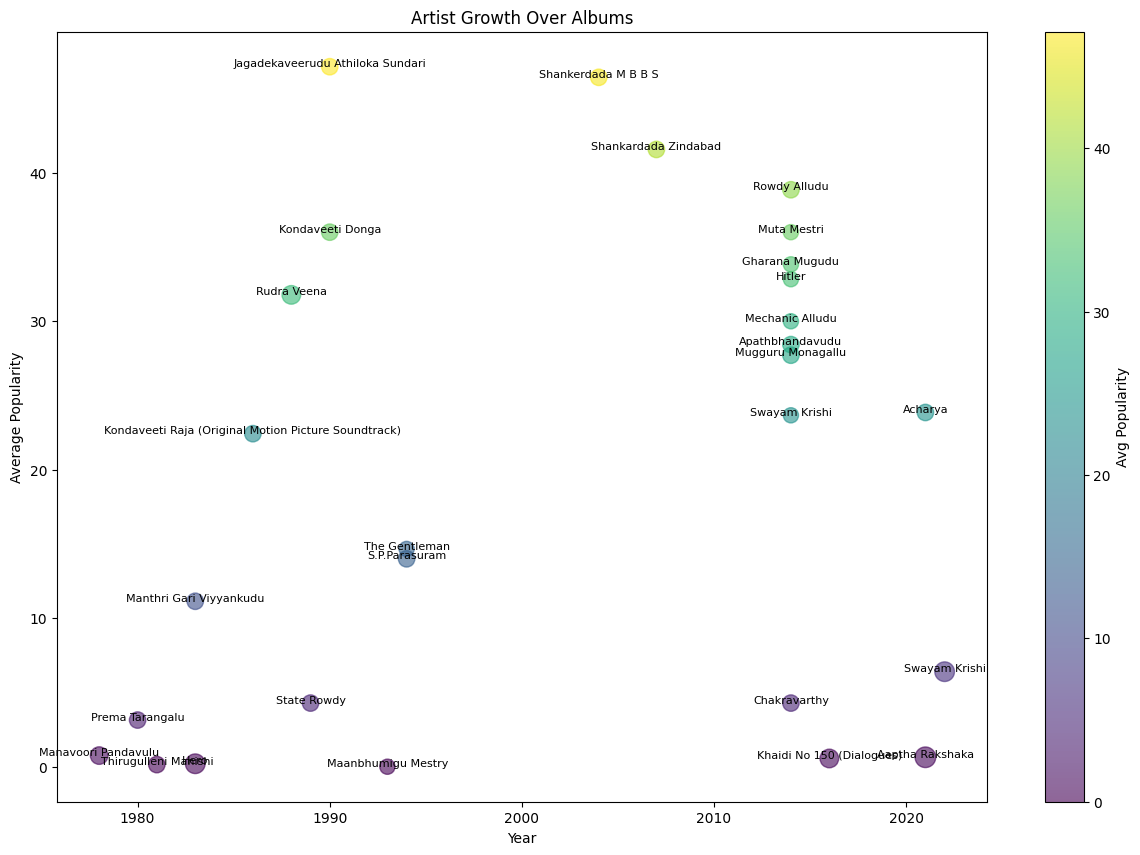

None


In [19]:
# artist growth example
df_growth = music.artist_growth_bubble("spotify:artist:1ufJdfFZl0Tui0VKz3qpXg") 
print(df_growth)

C:\Users\hi\AppData\Local\Temp\ipykernel_26548\2971070016.py:277: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="followers", y="name", data=df, palette="magma")


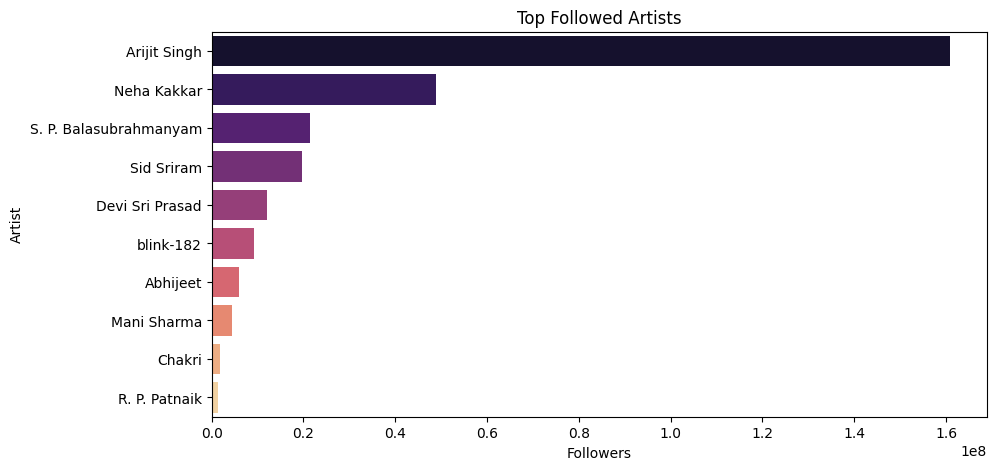

None


In [11]:
df_top_artists = music.top_artists_bar(limit=10)
print(df_top_artists)

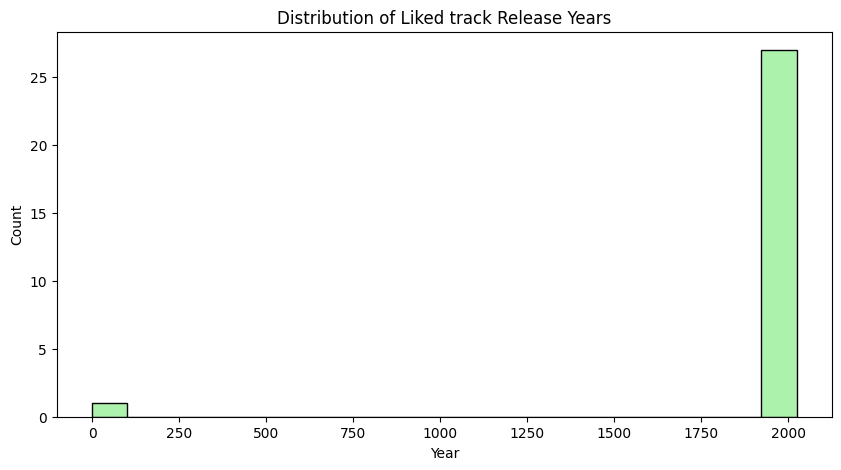

In [7]:
# year wise histogram for liked songs
music.release_year_distribution(limit=50)

In [12]:
print(music.generate_create_table_statement(df, table_name="spotify_liked_songs_data"))


        CREATE TABLE IF NOT EXISTS spotify_liked_songs_data (
        "index" INT,
    "artist" TEXT,
    "artist_id" TEXT,
    "name" TEXT,
    "id" TEXT,
    "url" TEXT,
    "album_name" TEXT,
    "album_id" TEXT,
    "release_date" TEXT,
    "duration_ms" INT,
    "explicit" BOOLEAN,
    "popularity" INT,
    "added_at" TEXT
        );
        


In [10]:
# Your PostgreSQL connection parameters
conn_params = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "901473R",
    "host": "localhost",
    "port": "5432"
}

# Example: your Spotify liked songs as DataFrame
df = pd.DataFrame(music.get_liked_songs(limit=50))

# Save to PostgreSQL
music.save_to_postgres(df, conn_params, table_name="spotify_liked_songs_data")

Data inserted successfully into table spotify_liked_songs_data


In [13]:
# Your PostgreSQL connection parameters
conn_params = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "901473R",
    "host": "localhost",
    "port": "5432"
}

music.read_from_postgresql(conn_params,table_name="spotify_liked_songs_data")

C:\Users\hi\AppData\Local\Temp\ipykernel_26548\2971070016.py:356: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {table_name}', conn)


,index,artist,artist_id,name,id,url,album_name,album_id,release_date,duration_ms,explicit,popularity,added_at
0,0,Shilpa Rao,19LIHDDSHBD5NyYHI3gpzB,"Chuttamalle (From ""Devara Part 1"")",1bxzr3JK05fMTcweGAZUHp,https://open.spotify.com/track/1bxzr3JK05fMTcw...,"Chuttamalle (From ""Devara Part 1"")",77bk7awXNSGEQkZTcTp2Gj,2024-08-05,222063,False,74,2024-08-12T16:55:30Z
1,1,S. P. Balasubrahmanyam,2ae6PxICSOZHvjqiCcgon8,Allantha Doorala,5jDcZCA2NJEvk7Kwa6bcE1,https://open.spotify.com/track/5jDcZCA2NJEvk7K...,Aadavari Matalaku Ardhalu Veruley,2MsMl4xvzwGfgaIy1BLm0u,2007-03-27,273293,False,55,2024-06-28T17:03:55Z
2,2,S. P. Balasubrahmanyam,2ae6PxICSOZHvjqiCcgon8,Suvvi Suvvi,2W21xyDCFlrgOzK2Yqv2X5,https://open.spotify.com/track/2W21xyDCFlrgOzK...,Swathi Mutyam,4iK9aG5KAiuGS1Wi8C9c3c,1985-01-01,341791,False,43,2024-06-28T12:09:58Z
3,3,Ghantasala,2spmKkD1aaIwksnFrAghRL,Prema Yatralaku,3NVSHFKnsSL0wxrgU9QqKo,https://open.spotify.com/track/3NVSHFKnsSL0wxr...,Gundaamma Katha,2nQf7vx5LS4Zn7citrSMbG,1962-12-31,202920,False,38,2024-06-28T12:09:24Z
4,4,Ghantasala,2spmKkD1aaIwksnFrAghRL,Nannu Dochu Kunduvatey,3AbxgsYRFyr6ycX60IeduW,https://open.spotify.com/track/3AbxgsYRFyr6ycX...,Gulebakavali Katha,07Z1vRSPAGAcnKv9X6HwPK,1962-12-31,206573,False,33,2024-06-28T12:08:16Z
5,5,Karthik,0LSPREIgGMZXCuKVel7LVD,Hoyna,2RB0HGpFZ3ScPEqC7uCqr3,https://open.spotify.com/track/2RB0HGpFZ3ScPEq...,Aata,0PkppaGtfsxVlibnWvhNdx,2007-04-26,306977,False,58,2024-06-28T12:03:04Z
6,6,Rajesh,6aQ5LDX0WlnyDLI8TGU0wK,Emainadho Emo,4A6j0Du0IrhL5F8smYVMTq,https://open.spotify.com/track/4A6j0Du0IrhL5F8...,Santhosham,5pZ7o500CAKbB4ciJVBNyl,2002-05-09,116550,False,43,2024-06-23T13:46:11Z
7,7,Mallikarjun,40Ce6P4AGMq3NXCDXVSZaa,Chitti Nadumune,4NugyVw9Of2Z4uyBXf33tX,https://open.spotify.com/track/4NugyVw9Of2Z4uy...,Gudumba Shankar,330aGp8Rl5dhqKoPRsY203,2004-08-09,354716,False,55,2024-06-23T13:44:22Z
8,8,Karthik,0LSPREIgGMZXCuKVel7LVD,Naa Pere Kanchanamaala,1e6r9GfyjrTUqmKohbswQn,https://open.spotify.com/track/1e6r9GfyjrTUqmK...,Shankerdada M B B S,2Dsq5t51lyNxZHm6bDdlbi,2004-10-15,319759,False,54,2024-06-23T13:44:08Z
9,9,Chakri,7puWXcCM8Li3HnKrxc1bEH,Ninne Ninne,6plyDAqUmEjWVPjM12udlU,https://open.spotify.com/track/6plyDAqUmEjWVPj...,Desamudhuru,5vGNfcsprKz9JRnLK13K3e,2006-12-23,277539,False,54,2024-06-23T13:43:33Z
